# Subset and cluster data using trained model

Using a trained model, this notebooks looks at how to cluster the latent space into ICLs. 
First, we will prepare the entire dataset for prediction.
Then, we will create a smaller subset of the large dataset for clustering

After this follows an interactive clustering step. This notebook contains some example code on how to quickly cluster the data and look at the results. We can also look at the clustering on example cells.

Finally, the resulting clustering can be annotated and projected to the entire data.



Use cluster directly to 
- created subsetted mpp data
- cluster (interactive way of doing this!) - use fn: Cluster.add_interactive_clustering(clustering)

within create_agg_data fn:
- Use predictor to predict latent from mpp_data (from within cluster)
- Use cluster to project final clustering

Use Aggregator to aggregate data + calculate stats etc (better name could be FeatureExtractor)

TODO run!

## Prepare full dataset for projecting cluster to it
Iterates over all data_dirs and predicts clustering. Recommended to run in script, as this can take a while:

`python cluster.py prepare-full test/VAE/aggregated/full_data`

In [23]:
import json
from miann.tl import Experiment, Predictor
from miann.constants import get_data_config
import os

exp = Experiment.from_dir('test/CondVAE_pert-CC')
save_dir = os.path.join(exp.full_path, 'aggregated', 'full_data')


rep = exp.config['cluster']['cluster_rep']
# iterate over all data dirs
for data_dir in exp.data_params['data_dirs']:
    print(f"Processing data_dir {data_dir}")
    mpp_data = MPPData.from_data_dir(data_dir)
    # params for partial saving of mpp_data
    mpp_params = {'base_data_dir':data_dir, 'subset': True}
    if mpp_data.data(rep) is not None:
        # just save mpp_data, rep is already present
        mpp_data.write(os.path.join(save_dir, data_dir), mpp_params=mpp_params, save_keys=[])
    else:
        # need to predict rep
        # prepare mpp_data
        print('Preparing data')
        data_config = get_data_config(exp.config['data']['data_config'])
        data_params = json.load(open(os.path.join(data_config.DATASET_DIR, exp.config['data']['dataset_name'], 'params.json'), 'r'))
        mpp_data.prepare(data_params)
        if data_params['neighborhood']:
            mpp_data.add_neighborhood(data_params['neighborhood_size'])
        # predict rep
        print('Predicting latent')
        pred = Predictor(exp)
        pred.predict(mpp_data, reps=[exp.config['cluster']['cluster_rep']], save_dir=os.path.join(save_dir, data_dir), mpp_params=mpp_params)


INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC


Processing data_dir 184A1_unperturbed/I09


INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.


Preparing data


INFO:MPPData:Restricted channels to 34 channels
INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per channels with predefined values
INFO:MPPData:Adding conditions: ['perturbation_duration_one_hot', 'cell_cycle_one_hot']
INFO:MPPData:Looking up condition perturbation_duration, with postprocess one_hot
INFO:convert_condition:Converting condition perturbation_duration to numbers
INFO:MPPData:Looking up condition cell_cycle, with postprocess one_hot
INFO:convert_condition:Converting condition cell_cycle to numbers
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to NO_NAN cell_cycle: 557 objects
INFO:MPPData:Subsetting to objects with NO_NAN condition: 557
INFO:MPPData:Adding neighborhood of size 3
INFO:Predictor:Creating Predictor for test/CondVAE_pert-CC


Predicting latent


2021-11-10 19:35:09.511198: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:VAEModel:Creating model
INFO:Estimator:Initializing model with weights from /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/weights_epoch010
INFO:MPPData:Created new: MPPData for NascentRNA (246467 mpps with shape (3, 3, 34) from 1768 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_test_dataset/train.
INFO:MPPData:Created new: MPPData for NascentRNA (11848 mpps with shape (3, 3, 34) from 88 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels

Processing data_dir 184A1_unperturbed/I11


INFO:MPPData:Created new: MPPData for NascentRNA (14097457 mpps with shape (1, 1, 35) from 1025 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I11.


Preparing data


INFO:MPPData:Restricted channels to 34 channels
INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per channels with predefined values
INFO:MPPData:Adding conditions: ['perturbation_duration_one_hot', 'cell_cycle_one_hot']
INFO:MPPData:Looking up condition perturbation_duration, with postprocess one_hot
INFO:convert_condition:Converting condition perturbation_duration to numbers
INFO:MPPData:Looking up condition cell_cycle, with postprocess one_hot
INFO:convert_condition:Converting condition cell_cycle to numbers
INFO:MPPData:Before subsetting: 1025 objects
INFO:MPPData:Subsetting to NO_NAN cell_cycle: 645 objects
INFO:MPPData:Subsetting to objects with NO_NAN condition: 645
INFO:MPPData:Adding neighborhood of size 3
INFO:Predictor:Creating Predictor for test/CondVAE_pert-CC


Predicting latent


INFO:VAEModel:Creating model
INFO:Estimator:Initializing model with weights from /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/weights_epoch010
INFO:MPPData:Created new: MPPData for NascentRNA (246467 mpps with shape (3, 3, 34) from 1768 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_test_dataset/train.
INFO:MPPData:Created new: MPPData for NascentRNA (11848 mpps with shape (3, 3, 34) from 88 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_test_dataset/val.
INFO:MPPData:Created new: MPPData for NascentRNA (14231 mpps with shape (3, 3, 34) from 101 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.sp

Processing data_dir 184A1_meayamycin/I12


INFO:MPPData:Created new: MPPData for NascentRNA (9629732 mpps with shape (1, 1, 35) from 556 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].
INFO:MPPData:Loaded data from 184A1_meayamycin/I12.


Preparing data


INFO:MPPData:Restricted channels to 34 channels
INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per channels with predefined values
INFO:MPPData:Adding conditions: ['perturbation_duration_one_hot', 'cell_cycle_one_hot']
INFO:MPPData:Looking up condition perturbation_duration, with postprocess one_hot
INFO:convert_condition:Converting condition perturbation_duration to numbers
INFO:MPPData:Looking up condition cell_cycle, with postprocess one_hot
INFO:convert_condition:Converting condition cell_cycle to numbers
INFO:MPPData:Before subsetting: 556 objects
INFO:MPPData:Subsetting to NO_NAN cell_cycle: 317 objects
INFO:MPPData:Subsetting to objects with NO_NAN condition: 317
INFO:MPPData:Adding neighborhood of size 3
INFO:Predictor:Creating Predictor for test/CondVAE_pert-CC
INFO:VAEModel:Creating model


Predicting latent


INFO:Estimator:Initializing model with weights from /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/weights_epoch010
INFO:MPPData:Created new: MPPData for NascentRNA (246467 mpps with shape (3, 3, 34) from 1768 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_test_dataset/train.
INFO:MPPData:Created new: MPPData for NascentRNA (11848 mpps with shape (3, 3, 34) from 88 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_test_dataset/val.
INFO:MPPData:Created new: MPPData for NascentRNA (14231 mpps with shape (3, 3, 34) from 101 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local

Processing data_dir 184A1_meayamycin/I20


INFO:MPPData:Created new: MPPData for NascentRNA (11794428 mpps with shape (1, 1, 35) from 692 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].
INFO:MPPData:Loaded data from 184A1_meayamycin/I20.


Preparing data


INFO:MPPData:Restricted channels to 34 channels
INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per channels with predefined values
INFO:MPPData:Adding conditions: ['perturbation_duration_one_hot', 'cell_cycle_one_hot']
INFO:MPPData:Looking up condition perturbation_duration, with postprocess one_hot
INFO:convert_condition:Converting condition perturbation_duration to numbers
INFO:MPPData:Looking up condition cell_cycle, with postprocess one_hot
INFO:convert_condition:Converting condition cell_cycle to numbers
INFO:MPPData:Before subsetting: 692 objects
INFO:MPPData:Subsetting to NO_NAN cell_cycle: 438 objects
INFO:MPPData:Subsetting to objects with NO_NAN condition: 438
INFO:MPPData:Adding neighborhood of size 3
INFO:Predictor:Creating Predictor for test/CondVAE_pert-CC
INFO:VAEModel:Creating model


Predicting latent


INFO:Estimator:Initializing model with weights from /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/weights_epoch010
INFO:MPPData:Created new: MPPData for NascentRNA (246467 mpps with shape (3, 3, 34) from 1768 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_test_dataset/train.
INFO:MPPData:Created new: MPPData for NascentRNA (11848 mpps with shape (3, 3, 34) from 88 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_test_dataset/val.
INFO:MPPData:Created new: MPPData for NascentRNA (14231 mpps with shape (3, 3, 34) from 101 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local

## Create subsetted mpp_data to cluster

`python cluster.py test/CondVAE_pred-CC create --subsample --frac 0.005 --save-dir aggregated/sub-0.005`

In [2]:
import logging
logging.basicConfig(level=logging.INFO)
from miann.tl import Experiment, Cluster

exp = Experiment.from_dir('test/CondVAE_pert-CC')
cl = Cluster.from_exp(exp, cluster_config={'subsample': True, 
    'subsample_kwargs': {'frac': 0.005}}, data_dir='aggregated/sub-0.005')

# create cluster_mpp
cl.create_cluster_mpp()
# predict rep
cl.predict_cluster_rep(exp)
# get umap
cl.add_umap()

Could not load MPPData from test/CondVAE_pert-CC/aggregated/sub-0.005
2021-11-10 19:06:03.357383: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-10 19:06:08.107328: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Saving partial keys of mpp data without a base_data_dir to enable correct loading


## Interactive, manual clustering of mpp_data
TODO the plotting functions and the whole process with several clusterings can be streamlined. Plotting functions should probably go in the package code

TODO once have improved plotting and integrated into code, should also use for plotting during evaluation

In [15]:
import logging
logging.basicConfig(level=logging.INFO)
from miann.tl import Cluster, Experiment
from miann.data import MPPData
import numpy as np
import os
from miann.constants import EXPERIMENT_DIR
import scanpy as sc
import pandas as pd
import seaborn as sns
from miann.tl._cluster import add_clustering_to_adata

In [3]:
# load cl
cluster_data_dir = 'test/CondVAE_pert-CC/aggregated/sub-0.005'
cl = Cluster.from_cluster_data_dir(cluster_data_dir)

INFO:MPPData:Created new: MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent'].
INFO:MPPData:Loaded data from test/CondVAE_pert-CC/aggregated/sub-0.005.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent'].


In [5]:
# get adata object
# NOTE can specify obs argument on get_adata call to directly load already computed clusterings
# but this has the disadvantage that the color maps are not set up correctly.
# prefer to use add_clustering_to_adata fn as shown in the following cell
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})

# cluster adata
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5, key_added='clustering_0.5')
sc.tl.leiden(adata, resolution=0.8, key_added='clustering_0.8')

# write clustering to disk
np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_0.5.npy'), adata.obs['clustering_0.5'])
np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_0.8.npy'), adata.obs['clustering_0.8'])

/Users/hannah.spitzer/opt/miniconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
# add clustering and colormap (from cluster_name_annotation.csv) to adata
# this is necessary to get the same colormaps in umap and whole-cell images
# NOTE Cluster fns internally use cl.config['custer_name'] - use cl.set_cluster_name to change it if looking at another clustering
cl.set_cluster_name('clustering_0.5') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir), 'clustering_0.5', adata, cl.cluster_annotation)

cl.set_cluster_name('clustering_0.8')
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir), 'clustering_0.8', adata, cl.cluster_annotation)


INFO:MPPData:Created new: MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'clustering_0.5', 'umap'].
INFO:MPPData:Loaded data from test/CondVAE_pert-CC/aggregated/sub-0.005.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'clustering_0.5', 'umap'].


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.005/clustering_0.5.npy


INFO:MPPData:Created new: MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'clustering_0.8', 'umap'].
INFO:MPPData:Loaded data from test/CondVAE_pert-CC/aggregated/sub-0.005.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'clustering_0.8', 'umap'].


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.005/clustering_0.8.npy


In [16]:
# quick plotting functions for looking at results
import matplotlib.pyplot as plt
def plot_loadings(var='clustering'):
    pixel_values_annotated = pd.concat([
        pd.DataFrame(adata.X,columns=adata.var_names).reset_index(drop=True),
        adata.obs[[var]].reset_index(drop=True)],
        axis=1)
    #col_standard = sns.clustermap(pixel_values_annotated.groupby(var).aggregate('mean'), z_score=0, cmap="vlag", figsize=[10,4],vmin=-3, vmax=3)
    row_standard = sns.clustermap(pixel_values_annotated.groupby(var).aggregate('mean'), z_score=1, cmap="vlag", figsize=[10,5],vmin=-3, vmax=3)

def plot_count_per_condition(var='clustering'):
    count_per_condition = adata.obs[['mapobject_id','perturbation_duration', var]].groupby(['perturbation_duration', var]).agg(['count'])
    count_per_condition.reset_index(level=0,inplace=True)
    count_per_condition = count_per_condition.pivot(columns='perturbation_duration')
    count_per_condition = count_per_condition / count_per_condition.sum()
    count_per_condition.index = count_per_condition.index.astype(int)
    count_per_condition = count_per_condition.sort_index()

    plt.rcParams['figure.figsize'] = [10, 14]
    fig,axes = plt.subplots(2,1)

    axes[0] = count_per_condition.plot.bar(ax=axes[0])
    axes[1] = sns.heatmap(count_per_condition.transpose())

# projection function to example subset
def project_clustering(cl, mpp_data: MPPData, obj_ids=[], num_objs=5, cluster_name='clustering'):
    """ 
    project clustering to example obj_ids. 
    Either a list of obj_ids can be specified, or a number of randomly drawn objects.

    Args:
        cl: reference clustering
        mpp_data: data containing the obj_ids to project
    """
    # set cluster_name to project
    cl.set_cluster_name(cluster_name)
    if len(obj_ids)==0:
        rng = np.random.default_rng(seed=42)
        obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
    sub_mpp_data = mpp_data.subset(obj_ids=obj_ids, copy=True)
    sub_mpp_data = cl.project_clustering(sub_mpp_data)
    return sub_mpp_data

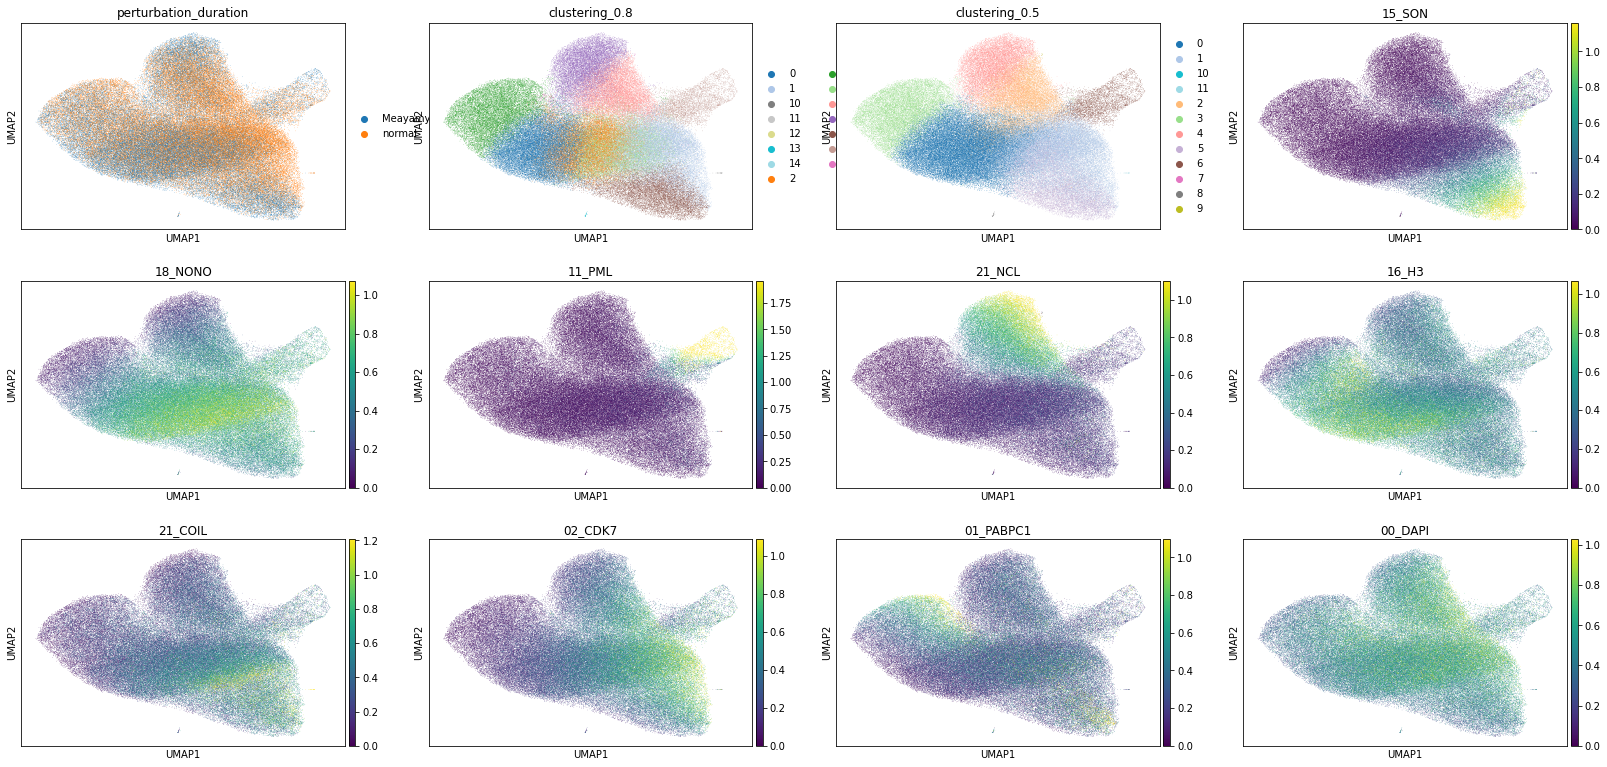

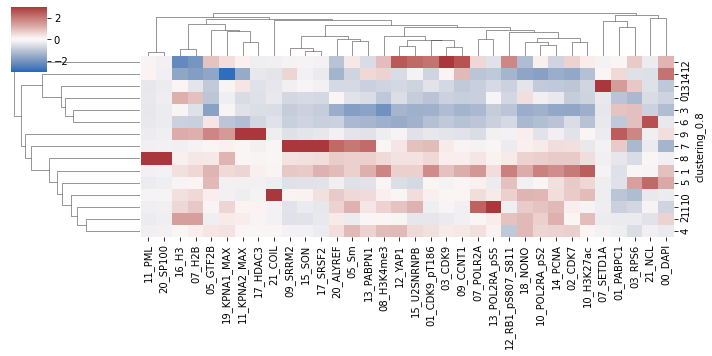

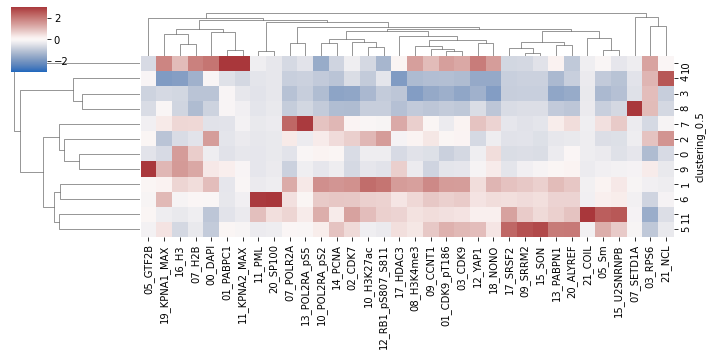

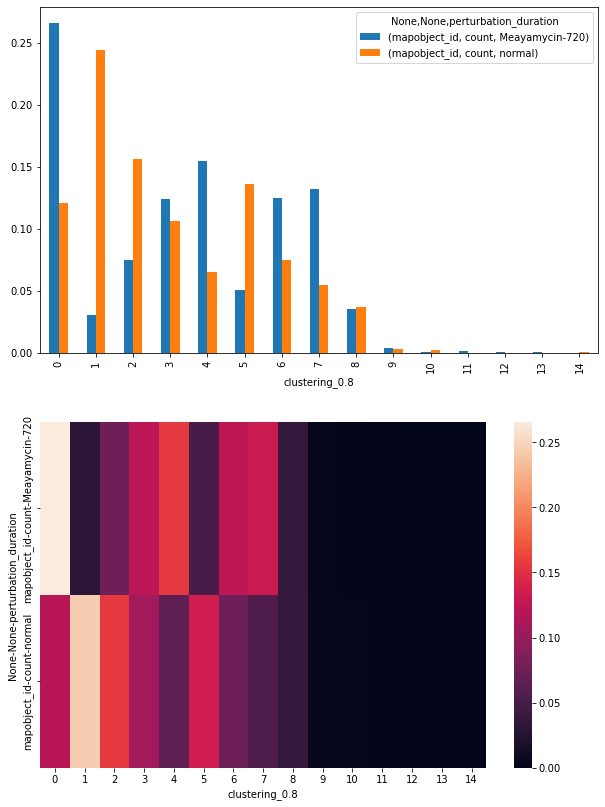

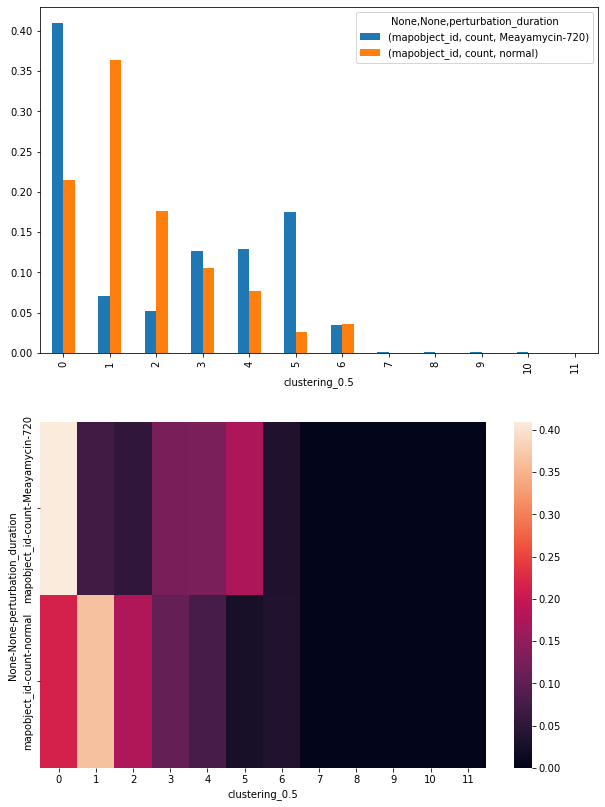

In [13]:
plt.rcParams['figure.figsize'] = [6, 4]
sc.pl.umap(adata, color=['perturbation_duration', 'clustering_0.8', 'clustering_0.5', '15_SON', '18_NONO', 
 '11_PML', '21_NCL', '16_H3', '21_COIL', '02_CDK7', '01_PABPC1', '00_DAPI'], vmax='p99')

plot_loadings('clustering_0.8')
plot_loadings('clustering_0.5')
plot_count_per_condition('clustering_0.8')
plot_count_per_condition('clustering_0.5')

In [39]:
# get mpp data for example cells
exp = Experiment.from_dir('test/CondVAE_pert-CC')
mpp_datas = {}
for data_dir in exp.data_params['data_dirs']:
    try:
        mpp_datas[data_dir] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(exp.full_path, 'aggregated/full_data'))
    except FileNotFoundError as e:
        continue

# get a few example cells (already colored). Repeat for different clusterings
cl.set_cluster_name('clustering_0.8')
example_cells_08 = {}
for data_dir, mpp_data in mpp_datas.items():
    sub_mpp_data = project_clustering(cl, mpp_data, num_objs=5, cluster_name='clustering_0.8')
    example_cells_08[data_dir] = sub_mpp_data.get_object_imgs(data='clustering_0.8', annotation_kwargs={'color': True, 'annotation': cl.cluster_annotation})

INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'mpp', 'labels', 'latent']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09
INFO:MPPData:Created new: MPPData for NascentRNA (14097457 mpps with shape (1, 1, 35) from 1025 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I11.
INFO:MPPData:Before subsetting: 1025 objects
INFO:MPPData:Subsetting to 645 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'mpp', 'labels', 'latent']
INFO:MPPData:Load

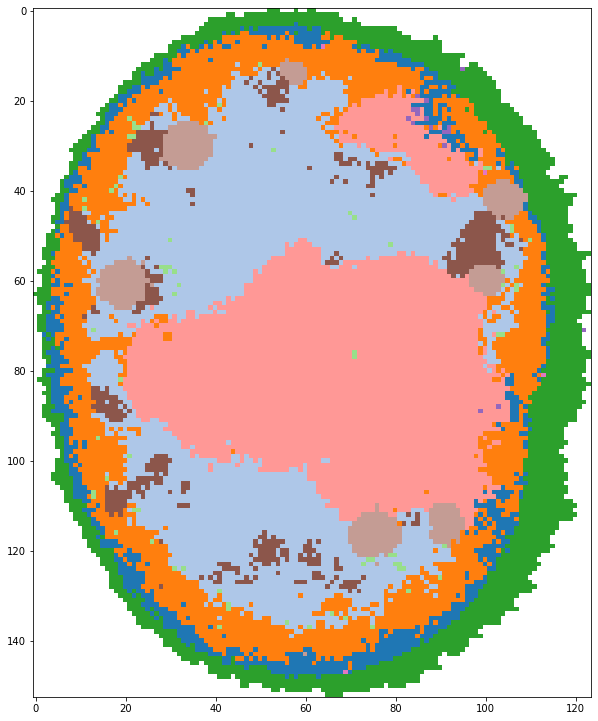

In [41]:
# plot example cells
plt.imshow(example_cells_08['184A1_unperturbed/I09'][1]))

In [ ]:
# TODO create and add annotation!


## Predict model on full data
`python cluster.py test/CondVAE_pert-CC project aggregated/sub-0.005 --save-dir aggregated/full_data --cluster-name clustering_0.5`

In [43]:
from miann.tl import Experiment, Cluster
from miann.data import MPPData

exp = Experiment.from_dir('test/CondVAE_pert-CC')
# set up cluster data
cl = Cluster.from_cluster_data_dir(os.path.join(exp.dir, exp.name, 'aggregated/sub-0.005'))
cl.set_cluster_name('clustering_0.5')
# iterate over all data dirs
data_dirs = exp.data_params['data_dirs']
for data_dir in data_dirs:
    # load mpp_data with cluster_rep
    mpp_data = MPPData.from_data_dir(data_dir, base_dir=os.path.join(exp.full_path, 'aggregated/full_data'), keys=['x', 'y', 'mpp', 'obj_ids', cl.config['cluster_rep']])
    cl.project_clustering(mpp_data, save_dir=os.path.join(exp.full_path, 'aggregated/full_data', data_dir))


INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:MPPData:Created new: MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'umap'].
INFO:MPPData:Loaded data from test/CondVAE_pert-CC/aggregated/sub-0.005.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'umap'].
INFO:MPPData:Created new: MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'clustering_0.5', 'umap'].
INFO:MPPData:Loaded data from test/CondVAE_pert-CC/aggregated/sub-0.005.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (136168 mpps with shape (3, 3, 34) from 1957 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'latent', 'clustering_0.5', 'umap'].


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.005/clustering_0.5.npy


INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'mpp', 'labels', 'latent']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09
INFO:Cluster:Projecting clustering to 7218204 samples
INFO:Cluster:processing chunk 0
INFO:Cluster:processing chunk 200000
INFO:Cluster:processing chunk 400000
INFO:Cluster:processing chunk 600000
INFO:Cluster:processing chunk 800000
INFO:Cluster:processing chunk 1000000
INFO:Cluster:processing chunk 1200000
INFO:Cluster:processing chunk 1400000
INFO:Cluster:processing chunk 1600000
INFO:Cluster:processing chunk 1800000
INFO:Cluster:processing chunk 2000000
INFO:Cluster:processing chunk 2200000
INFO:Cluster:processing chunk 